# Detecting hot posts by classification

1. 目的：我們收到社群輿論資料共一萬多筆貼文（posts），想要從裡面建立一個分類模型來偵測什麼樣的貼文會「爆」（假設某則post有超過100則回文（comments），以PTT的語彙來說，就是爆了）。
2. 依變項（Dependent）：依變項為每則posts的回文數，把100則回文以上的文章視為1，把少於100則回文的視為0（切勿不可將回文數當成自變項，如果這麼做就會被扣很多分數）。但你也可以嘗試以不一樣的方式去切割，但要注意盡可能保持1/0兩個分類貼文數的平衡。
3. 自變項（Independent）：至少要以貼文內容作為自變項，但可以用貼文標題、貼文作者、貼文時間來訓練。除此之外，我們還提供了前10則回文，說不定影響一則貼文會不會爆的主要因素是前十則回文。你可以自己決定要不要把回文丟下去當自變項。本作業的要求只有要求要用貼文當自變項。
4. 參考版本：助教用simpletransformer寫了個[版本](https://colab.research.google.com/drive/1YQZNlzH_mo7_Q3XU8X2sIpkhrQZWVYar?usp=sharing)給各位參考，但作為示範助教僅使用了貼文內容作為特徵來訓練模型、也使用了較少的資料集（在時間上做了點切割）。你可以使用全部的貼文來預測，或者可以嘗試加入每則貼文的前10則回文來預測。


# 讀取資料
1. 貼文資料https://github.com/p4css/PSS/blob/master/data/ptt_post.pickle
2. 回文資料https://github.com/p4css/PSS/blob/master/data/ptt_comment10.pickle 
貼文與相對應的回文資料均以plink作為key，可以用pandas的merge將兩個資料集給連結起來做訓練。但要怎麼把前十則的回文化為貼文特徵，要想想。

In [2]:
import pandas as pd
import numpy as np
import re
import unicodedata
import jieba
df = pd.read_pickle('data/ptt_post.pickle')

#將"爆"的貼文設定為1，訂在df['explode']
explosion = []
for comm in df['Ncomment']:
    if comm >= 100:
        explosion.append(1)
    else:
        explosion.append(0)

df['explode'] = explosion

#清理貼文內容
df['cleaned'] = df.pcontent.apply(lambda x: re.sub(r'\n+', '\n', x).strip())
df['cleaned'] = df.cleaned.apply(lambda x: x.replace('\n', ' ').strip()[:])
df['token_text'] = df['cleaned'].apply(lambda x:list(jieba.cut(x)))

df.head(5)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 2.618 seconds.
Prefix dict has been built successfully.


,plink,board,pcontent,poster,ptitle,ptime,ipaddr,ip.len,Ncomment,explode,cleaned,token_text
0,https://www.ptt.cc/bbs/Gossiping/M.1119222660....,Gossiping,"\n\n 看到這推文,忍不住要寫一個飛機沒油的例子\n 很久之前在讀者文摘上看到,現憑印象寫...",Muroi (I Honestly Love You),Re: (問題)華航空難留言,Mon Jun 20 07:28:27 2005,138.130.212.179,1,944,1,"看到這推文,忍不住要寫一個飛機沒油的例子 很久之前在讀者文摘上看到,現憑印象寫文,有錯請指...","[看到, 這推文, ,, 忍不住, 要, 寫, 一個, 飛機, 沒油, 的, 例子, , ..."
1,https://www.ptt.cc/bbs/Gossiping/M.1119233779....,Gossiping,\n那不是為了反盜版\n那是為了捐錢給消基會\n當年美國唱了 WE ARE THE WORL...,JCC (JCC ),Re: 有沒有明天會更好的八卦,Mon Jun 20 10:21:53 2005,211.20.78.69,1,350,1,那不是為了反盜版 那是為了捐錢給消基會 當年美國唱了 WE ARE THE WORLD之後 ...,"[那, 不是, 為, 了, 反盜, 版, , 那, 是, 為, 了, 捐, 錢給, 消基會..."
2,https://www.ptt.cc/bbs/Gossiping/M.1119257927....,Gossiping,\n\n我聽到的是：\n記者問張跟路有沒有要結婚\n 家人有沒有在催。。。巴拉巴拉的\n...,vancie (我不正 我很歪 ),Re: [新聞] 張震月的八卦有嗎？,Mon Jun 20 17:07:13 2005,※ 發信站: 批踢踢實業坊(ptt.cc),0,156,1,我聽到的是： 記者問張跟路有沒有要結婚 家人有沒有在催。。。巴拉巴拉的 張覺得很煩，就...,"[我, 聽, 到, 的, 是, ：, , 記者, 問張, 跟, 路, 有, 沒, 有, 要..."
3,https://www.ptt.cc/bbs/Gossiping/M.1119258686....,Gossiping,"\n太想被M,得到P幣\n再八卦一下\n\n桌伯元先生真的不是台大法學碩士\n\n它是\n國...",J1 (andy),Re: [政商] 請問桌伯元的八卦?,Mon Jun 20 17:18:14 2005,220.141.159.23,1,160,1,"太想被M,得到P幣 再八卦一下 桌伯元先生真的不是台大法學碩士 它是 國立台灣大學法律系學士...","[太想, 被, M, ,, 得到, P, 幣, , 再, 八卦, 一下, , 桌伯元, ..."
4,https://www.ptt.cc/bbs/Gossiping/M.1119271499....,Gossiping,\n\n米其林是家輪胎公司\n米其林兄弟發行了一本只送不賣的輪胎手冊\n讓所有自動車 自行車...,ilcd (南特 巴黎 白朗峰!!! ),Re: 有沒有米其淋的美食還是什麼評鑑八卦,Mon Jun 20 20:53:24 2005,218.167.152.79,1,153,1,米其林是家輪胎公司 米其林兄弟發行了一本只送不賣的輪胎手冊 讓所有自動車 自行車 機車的車主...,"[米其林, 是, 家, 輪胎, 公司, , 米其林, 兄弟, 發行, 了, 一本, 只, ..."


In [3]:
#remove punctuation
def remove_punc_by_unicode(words):
    out = []
    for word in words:
        if word != " " and not unicodedata.category(word[0]).startswith('P'):
            out.append(word)
    return out

df['final_cleaned'] = df['token_text'].apply(remove_punc_by_unicode)
# post = post.sample(frac=0.5)
df.head()
        

# print(df['explode'].value_counts())

,plink,board,pcontent,poster,ptitle,ptime,ipaddr,ip.len,Ncomment,explode,cleaned,token_text,final_cleaned
0,https://www.ptt.cc/bbs/Gossiping/M.1119222660....,Gossiping,"\n\n 看到這推文,忍不住要寫一個飛機沒油的例子\n 很久之前在讀者文摘上看到,現憑印象寫...",Muroi (I Honestly Love You),Re: (問題)華航空難留言,Mon Jun 20 07:28:27 2005,138.130.212.179,1,944,1,"看到這推文,忍不住要寫一個飛機沒油的例子 很久之前在讀者文摘上看到,現憑印象寫文,有錯請指...","[看到, 這推文, ,, 忍不住, 要, 寫, 一個, 飛機, 沒油, 的, 例子, , ...","[看到, 這推文, 忍不住, 要, 寫, 一個, 飛機, 沒油, 的, 例子, 很, 久, ..."
1,https://www.ptt.cc/bbs/Gossiping/M.1119233779....,Gossiping,\n那不是為了反盜版\n那是為了捐錢給消基會\n當年美國唱了 WE ARE THE WORL...,JCC (JCC ),Re: 有沒有明天會更好的八卦,Mon Jun 20 10:21:53 2005,211.20.78.69,1,350,1,那不是為了反盜版 那是為了捐錢給消基會 當年美國唱了 WE ARE THE WORLD之後 ...,"[那, 不是, 為, 了, 反盜, 版, , 那, 是, 為, 了, 捐, 錢給, 消基會...","[那, 不是, 為, 了, 反盜, 版, 那, 是, 為, 了, 捐, 錢給, 消基會, 當..."
2,https://www.ptt.cc/bbs/Gossiping/M.1119257927....,Gossiping,\n\n我聽到的是：\n記者問張跟路有沒有要結婚\n 家人有沒有在催。。。巴拉巴拉的\n...,vancie (我不正 我很歪 ),Re: [新聞] 張震月的八卦有嗎？,Mon Jun 20 17:07:13 2005,※ 發信站: 批踢踢實業坊(ptt.cc),0,156,1,我聽到的是： 記者問張跟路有沒有要結婚 家人有沒有在催。。。巴拉巴拉的 張覺得很煩，就...,"[我, 聽, 到, 的, 是, ：, , 記者, 問張, 跟, 路, 有, 沒, 有, 要...","[我, 聽, 到, 的, 是, 記者, 問張, 跟, 路, 有, 沒, 有, 要, 結婚, ..."
3,https://www.ptt.cc/bbs/Gossiping/M.1119258686....,Gossiping,"\n太想被M,得到P幣\n再八卦一下\n\n桌伯元先生真的不是台大法學碩士\n\n它是\n國...",J1 (andy),Re: [政商] 請問桌伯元的八卦?,Mon Jun 20 17:18:14 2005,220.141.159.23,1,160,1,"太想被M,得到P幣 再八卦一下 桌伯元先生真的不是台大法學碩士 它是 國立台灣大學法律系學士...","[太想, 被, M, ,, 得到, P, 幣, , 再, 八卦, 一下, , 桌伯元, ...","[太想, 被, M, 得到, P, 幣, 再, 八卦, 一下, 桌伯元, 先生, 真的, 不..."
4,https://www.ptt.cc/bbs/Gossiping/M.1119271499....,Gossiping,\n\n米其林是家輪胎公司\n米其林兄弟發行了一本只送不賣的輪胎手冊\n讓所有自動車 自行車...,ilcd (南特 巴黎 白朗峰!!! ),Re: 有沒有米其淋的美食還是什麼評鑑八卦,Mon Jun 20 20:53:24 2005,218.167.152.79,1,153,1,米其林是家輪胎公司 米其林兄弟發行了一本只送不賣的輪胎手冊 讓所有自動車 自行車 機車的車主...,"[米其林, 是, 家, 輪胎, 公司, , 米其林, 兄弟, 發行, 了, 一本, 只, ...","[米其林, 是, 家, 輪胎, 公司, 米其林, 兄弟, 發行, 了, 一本, 只, 送, ..."


In [4]:
print(df.at[4, 'ptitle'][:])
df['token_title'] = df['ptitle'].astype("str").apply(lambda x:list(jieba.cut(x)))

df['token_title'] = df['token_title'].apply(remove_punc_by_unicode)


def plus_t(words):
    out = []
    for word in words:
        out.append("t"+word)
    return out
df['token_title'] = df['token_title'].apply(plus_t)

df.head()
# df['cleaned_title'] = df.ptitle.apply(lambda x: str.replace("Re: ", " "))
# df.head(2)
# def clean_title(words):
#     out = []
#     for word in words:

Re: 有沒有米其淋的美食還是什麼評鑑八卦


,plink,board,pcontent,poster,ptitle,ptime,ipaddr,ip.len,Ncomment,explode,cleaned,token_text,final_cleaned,token_title
0,https://www.ptt.cc/bbs/Gossiping/M.1119222660....,Gossiping,"\n\n 看到這推文,忍不住要寫一個飛機沒油的例子\n 很久之前在讀者文摘上看到,現憑印象寫...",Muroi (I Honestly Love You),Re: (問題)華航空難留言,Mon Jun 20 07:28:27 2005,138.130.212.179,1,944,1,"看到這推文,忍不住要寫一個飛機沒油的例子 很久之前在讀者文摘上看到,現憑印象寫文,有錯請指...","[看到, 這推文, ,, 忍不住, 要, 寫, 一個, 飛機, 沒油, 的, 例子, , ...","[看到, 這推文, 忍不住, 要, 寫, 一個, 飛機, 沒油, 的, 例子, 很, 久, ...","[tRe, t問題, t華, t航空, t難, t留言]"
1,https://www.ptt.cc/bbs/Gossiping/M.1119233779....,Gossiping,\n那不是為了反盜版\n那是為了捐錢給消基會\n當年美國唱了 WE ARE THE WORL...,JCC (JCC ),Re: 有沒有明天會更好的八卦,Mon Jun 20 10:21:53 2005,211.20.78.69,1,350,1,那不是為了反盜版 那是為了捐錢給消基會 當年美國唱了 WE ARE THE WORLD之後 ...,"[那, 不是, 為, 了, 反盜, 版, , 那, 是, 為, 了, 捐, 錢給, 消基會...","[那, 不是, 為, 了, 反盜, 版, 那, 是, 為, 了, 捐, 錢給, 消基會, 當...","[tRe, t有, t沒, t有, t明天, t會, t更好, t的, t八卦]"
2,https://www.ptt.cc/bbs/Gossiping/M.1119257927....,Gossiping,\n\n我聽到的是：\n記者問張跟路有沒有要結婚\n 家人有沒有在催。。。巴拉巴拉的\n...,vancie (我不正 我很歪 ),Re: [新聞] 張震月的八卦有嗎？,Mon Jun 20 17:07:13 2005,※ 發信站: 批踢踢實業坊(ptt.cc),0,156,1,我聽到的是： 記者問張跟路有沒有要結婚 家人有沒有在催。。。巴拉巴拉的 張覺得很煩，就...,"[我, 聽, 到, 的, 是, ：, , 記者, 問張, 跟, 路, 有, 沒, 有, 要...","[我, 聽, 到, 的, 是, 記者, 問張, 跟, 路, 有, 沒, 有, 要, 結婚, ...","[tRe, t新聞, t張震, t月, t的, t八卦, t有, t嗎]"
3,https://www.ptt.cc/bbs/Gossiping/M.1119258686....,Gossiping,"\n太想被M,得到P幣\n再八卦一下\n\n桌伯元先生真的不是台大法學碩士\n\n它是\n國...",J1 (andy),Re: [政商] 請問桌伯元的八卦?,Mon Jun 20 17:18:14 2005,220.141.159.23,1,160,1,"太想被M,得到P幣 再八卦一下 桌伯元先生真的不是台大法學碩士 它是 國立台灣大學法律系學士...","[太想, 被, M, ,, 得到, P, 幣, , 再, 八卦, 一下, , 桌伯元, ...","[太想, 被, M, 得到, P, 幣, 再, 八卦, 一下, 桌伯元, 先生, 真的, 不...","[tRe, t政商, t請問, t桌伯元, t的, t八卦]"
4,https://www.ptt.cc/bbs/Gossiping/M.1119271499....,Gossiping,\n\n米其林是家輪胎公司\n米其林兄弟發行了一本只送不賣的輪胎手冊\n讓所有自動車 自行車...,ilcd (南特 巴黎 白朗峰!!! ),Re: 有沒有米其淋的美食還是什麼評鑑八卦,Mon Jun 20 20:53:24 2005,218.167.152.79,1,153,1,米其林是家輪胎公司 米其林兄弟發行了一本只送不賣的輪胎手冊 讓所有自動車 自行車 機車的車主...,"[米其林, 是, 家, 輪胎, 公司, , 米其林, 兄弟, 發行, 了, 一本, 只, ...","[米其林, 是, 家, 輪胎, 公司, 米其林, 兄弟, 發行, 了, 一本, 只, 送, ...","[tRe, t有, t沒, t有, t米, t其淋, t的, t美食, t還是, t什麼, ..."


In [5]:
with open("data/stopwords_zh-tw.txt", encoding="utf-8") as fin:
    stopwords = fin.read().split("\n")[1:]
stopwords.append('\u3000')
from sklearn.feature_extraction.text import TfidfVectorizer

#document1=內文，document2=標題，將兩者混和在一起丟進document中
documents1 = [" ".join(doc) for doc in df['final_cleaned']]
documents2 = [" ".join(doc) for doc in df['token_title']]
documents = []
for i in range(len(documents1)):
    documents.append(documents2[i] +" "+ documents1[i])
print(documents[1])


# X1 = np.asarray(df[['city', 'num_employees', 'store', 'units_sold']])



model_tfidf = TfidfVectorizer(max_df=0.05,
                              # token_pattern=r"(?u)\b\w+\b", 
                              # max_features = 2000,
                              stop_words=stopwords).fit(documents)


X_tfidf = model_tfidf.transform(documents)
print(type(X_tfidf))
print(X_tfidf.shape)
# print(X_tfidf)
# model_tfidf.inverse_transform(X_tfidf)[:20]

tRe t有 t沒 t有 t明天 t會 t更好 t的 t八卦 那 不是 為 了 反盜 版 那 是 為 了 捐 錢給 消基會 當年 美國 唱 了 WE ARE THE WORLD 之 後 台灣 這些 歌手 也 覺得 該 如法 泡 製 一番 但 當年 國家 安定 人民富足 實在 找不出 啥 理由 於 是 就 拿 來 捐給 消基會 了 至於 為後來 很多 人會誤 傳是 為 了 反盜 版 我 也 不 知道 大慨 是 捐給 消基會 這個 理由 蠻妙 的 吧 以上 是 我 記憶 的 東西 網 路上 找到 一篇 文 可以 佐證 當年 大合唱 的 歌曲 還有 滾石 的 快樂 天堂 唱給 動物園 搬家 用 的 還有 飛 碟 的 飛向 未來 好像 只是 幾 周年 慶用 的 至於 後 來 八九天 安門 屠殺 後 的 歷史 的 傷口 讓 童安格 被 大陸禁 了 好 幾年 ◆ From 211.20 78.69
<class 'scipy.sparse.csr.csr_matrix'>
(12149, 220906)


# 切割資料集

In [6]:
from sklearn.model_selection import train_test_split
#將explode變相設為y
y = df.iloc[:, 9]
X_train, X_test, y_train, y_test = train_test_split(documents, y, test_size=0.3)

# 訓練模型

## 篩選tfidf變數

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [93]:

pipe= Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', LogisticRegression())
    # ('RF': RandomForestClassifier()),
    # ('NB': GaussianNB())
])


parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.01, 0.05, 0.1, 0.2, 1.0],
#     'tfidf__token_pattern': [r"(?u)\b\w+\b", r"(?u)\b\w\w+\b"],
    'tfidf__max_features': [10000, 15000, 20000]
#     'clf__penalty': ('l1', 'l2', 'none'),
}

grid = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose = 3)
grid.fit(documents, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['?', '、',
                                                                    '。', '“',
                                                                    '”', '《',
                                                                    '》', '！',
                                                                    '，', '：',
                                                                    '；', '？',
                                                                    '人民',
                                                                    '末##末', '啊',
                                                                    '阿', '哎',
                                                                    '哎呀', '哎喲',
                                                                    '唉', '我',
                                                                    '我們',

In [94]:
print(grid.best_score_)
print("Params: ")
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid.best_params_[param_name]))

0.6801393653843222
Params: 
tfidf__max_df: 1.0
tfidf__max_features: 20000
tfidf__ngram_range: (1, 2)


In [95]:

pd.DataFrame(grid.cv_results_).filter(regex='(param_.*)|(.*test_score)')

,param_tfidf__max_df,param_tfidf__max_features,param_tfidf__ngram_range,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,10000,"(1, 1)",0.578601,0.614815,0.612346,0.594239,0.617126,0.603425,0.014817,30
1,0.01,10000,"(1, 2)",0.576132,0.616049,0.623457,0.605350,0.606834,0.605564,0.016112,28
2,0.01,15000,"(1, 1)",0.576543,0.614403,0.616049,0.596296,0.615068,0.603672,0.015418,29
3,0.01,15000,"(1, 2)",0.583951,0.616049,0.628807,0.610288,0.620420,0.611903,0.015228,26
4,0.01,20000,"(1, 1)",0.577778,0.615226,0.617284,0.602058,0.618361,0.606141,0.015344,27
5,0.01,20000,"(1, 2)",0.589712,0.608642,0.629630,0.610700,0.624125,0.612562,0.013899,25
6,0.05,10000,"(1, 1)",0.606173,0.630041,0.650206,0.621399,0.643886,0.630341,0.015762,24
7,0.05,10000,"(1, 2)",0.610700,0.635802,0.655144,0.632922,0.648827,0.636679,0.015351,21
8,0.05,15000,"(1, 1)",0.608230,0.627160,0.655967,0.627160,0.641828,0.632069,0.016018,23
9,0.05,15000,"(1, 2)",0.605350,0.634979,0.657202,0.637037,0.652120,0.637338,0.018122,19


## 用chi2跑跑看

In [18]:
#用跑完後比較好的參數
model_tfidf = TfidfVectorizer(max_df=1.0,
                              ngram_range = (1,2),
                              use_idf = False,
                              # token_pattern=r"(?u)\b\w+\b", 
                              max_features = 8000,
                              stop_words=stopwords).fit(documents)


X_tfidf = model_tfidf.transform(documents)

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(score_func=chi2, k=3000)
fit = selector.fit(X_tfidf, y)
# fit.scores_
X_chi2=selector.fit_transform(X_tfidf, y)
X_chi2

<12149x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 584072 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def train_model(classifier, train, train_label, test, test_label):
    classifier.fit(train, train_label)
    pred_label = classifier.predict(test)
    print(confusion_matrix(test_label, pred_label))
    print(classification_report(test_label, pred_label))

X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf.toarray(), y, test_size=0.3)
X_chi2_train, X_chi2_test, y_chi2_train, y_chi2_test = train_test_split(X_chi2.toarray(), y, test_size=0.3)

# print(X_tfidf_train.shape)
# print(X_chi2_train.shape)

#tfidf + LR
train_model(LogisticRegression(), X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test)

#chi2 + LR
train_model(LogisticRegression(), X_chi2_train, y_chi2_train, X_chi2_test, y_chi2_test)

[[1134  645]
 [ 477 1389]]
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      1779
           1       0.68      0.74      0.71      1866

    accuracy                           0.69      3645
   macro avg       0.69      0.69      0.69      3645
weighted avg       0.69      0.69      0.69      3645

[[1162  598]
 [ 492 1393]]
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1760
           1       0.70      0.74      0.72      1885

    accuracy                           0.70      3645
   macro avg       0.70      0.70      0.70      3645
weighted avg       0.70      0.70      0.70      3645



## 測試其他種model
(因為電腦會跑到當機，所以其他model就不做optimization了)

In [20]:
#tfidf + Bayes
train_model(GaussianNB(), X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test)

#chi2 + Bayes
train_model(GaussianNB(), X_chi2_train, y_chi2_train, X_chi2_test, y_chi2_test)

[[1162  617]
 [ 736 1130]]
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      1779
           1       0.65      0.61      0.63      1866

    accuracy                           0.63      3645
   macro avg       0.63      0.63      0.63      3645
weighted avg       0.63      0.63      0.63      3645

[[1321  439]
 [ 752 1133]]
              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1760
           1       0.72      0.60      0.66      1885

    accuracy                           0.67      3645
   macro avg       0.68      0.68      0.67      3645
weighted avg       0.68      0.67      0.67      3645



In [21]:
# #tfidf + bootstrap
# print("tfidf + bootstrap")
# train_model(GradientBoostingClassifier(), X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test)
# print("="*100)

# #chi2 + bootstrap
# print("chi2 + bootstrap")
# train_model(GradientBoostingClassifier(), X_chi2_train, y_chi2_train, X_chi2_test, y_chi2_test)
# print("="*100)

#tfidf + randomforest
print("tfidf + randomforest")
train_model(RandomForestClassifier(), X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test)
print("="*100)

#chi2 + randomforest
print("chi2 + randomforest")
train_model(RandomForestClassifier(), X_chi2_train, y_chi2_train, X_chi2_test, y_chi2_test)

tfidf + randomforest
[[1169  610]
 [ 484 1382]]
              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1779
           1       0.69      0.74      0.72      1866

    accuracy                           0.70      3645
   macro avg       0.70      0.70      0.70      3645
weighted avg       0.70      0.70      0.70      3645

chi2 + randomforest
[[1141  619]
 [ 518 1367]]
              precision    recall  f1-score   support

           0       0.69      0.65      0.67      1760
           1       0.69      0.73      0.71      1885

    accuracy                           0.69      3645
   macro avg       0.69      0.69      0.69      3645
weighted avg       0.69      0.69      0.69      3645



# 預測結果
預測結果應包含`classification_report`並應用`from mlxtend.plotting import plot_confusion_matrix`繪製confision_matrix的視覺化結果。

In [27]:
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix

tfidf + logistic regression


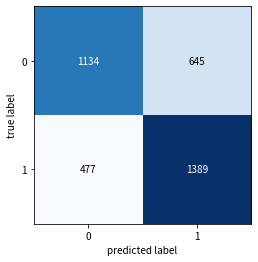

chi2 + logistic regression


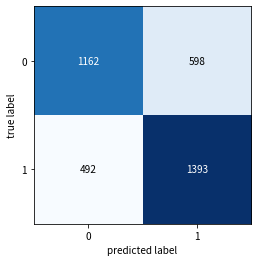

tfidf + randomforest


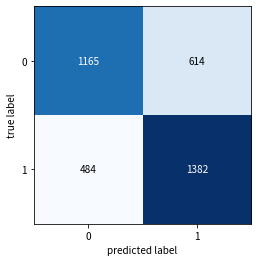

chi2 + randomforest


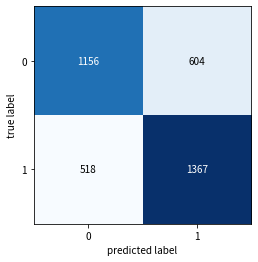

tfidf + Bayes


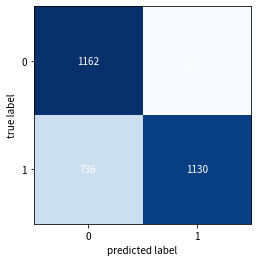

chi2 + Bayes


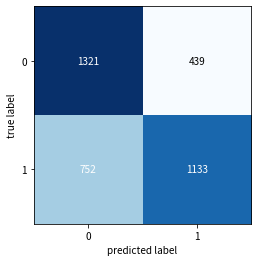

In [30]:
def cm_model(classifier, train, train_label, test, test_label):
    classifier.fit(train, train_label)
    pred_label = classifier.predict(test)
    return confusion_matrix(test_label, pred_label)

print("tfidf + logistic regression")
cm_1 = cm_model(LogisticRegression(), X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test)
fig, ax = plot_confusion_matrix(conf_mat=cm_1)
plt.show()
plt.close()
print("="*100)

print("chi2 + logistic regression")
cm_2 = cm_model(LogisticRegression(), X_chi2_train, y_chi2_train, X_chi2_test, y_chi2_test)
fig, ax = plot_confusion_matrix(conf_mat=cm_2)
plt.show()
plt.close()
print("="*100)

print("tfidf + randomforest")
cm_3 = cm_model(RandomForestClassifier(), X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test)
fig, ax = plot_confusion_matrix(conf_mat=cm_3)
plt.show()
plt.close()
print("="*100)

print("chi2 + randomforest")
cm_4 = cm_model(RandomForestClassifier(), X_chi2_train, y_chi2_train, X_chi2_test, y_chi2_test)
fig, ax = plot_confusion_matrix(conf_mat=cm_4)
plt.show()
plt.close()
print("="*100)

print("tfidf + Bayes")
cm_5 = cm_model(GaussianNB(), X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test)
fig, ax = plot_confusion_matrix(conf_mat=cm_5)
plt.show()
plt.close()
print("="*100)

print("chi2 + Bayes")
cm_6 = cm_model(GaussianNB(), X_chi2_train, y_chi2_train, X_chi2_test, y_chi2_test)
fig, ax = plot_confusion_matrix(conf_mat=cm_6)
plt.show()
plt.close()


# 分析預測結果
Q1. 你把什麼樣的特徵丟進去當自變項（最基本要有貼文，但你還可以丟貼文的發文者、時間、標題、前十則回文內容、回文作者）？
> 我丟了「貼文內容與標題」作自變項，只是我為了將標題內的字詞與內文的字詞分開做考慮，所以將內文的斷詞結果存在documents1，標題的斷詞結果每個詞加上前綴"t"存入socuments2，再將兩者合併成一個documents後丟進tfidf做featuring。

Q2. 你認為這個模型的分類能力好嗎？請說明模型訓練結果。
> 我覺得訓練效果還可以吧，看最後confusion matrix的結果也沒有甚麼imbalance的現象，只是好像因為記憶體容量不夠所以不能將tfidf的 max features數量射程最optimize的20000筆，只能在tfidf抓最大的8000的變數，chi2抓最大的3000個變數去試試各個模型。

> 以經過optimize的LR model來說有0.7的precision rate跟recall rate，且轉換成使用chi2(k=3000)時訓練結果也沒有甚麼變化，只有0的recall rate跟1的precision rate增加2%。然而因為電腦配置的關係我沒有再針對其他其他model做optimize，這時就能看到"使用LR optimize後的X自變項參數"運用在其他model上效果有點參差不齊。在bayes model不論是precision rate或是recall rate平均都掉了3~5%的準確率，但在random forest下跑出來的acurracy差不多。

Q3. 你認為ptt貼文內容適合拿來做訓練資料嗎？為什麼？
> 我覺得應該不太好，斷詞後的內容實在是太多了(在加入max features前有22萬筆features)。相對地代表每一篇文章的vector就沒甚麼代表性。

Q4. 若加入其他參考特徵後，模型有什麼樣的改變呢（如果你沒做的話就不用回答）？
> 雖然我沒有做加入標題內容的前後對比看模型跑出來的結果，但我覺得加入標題變項後對於訓練出來的結果應有不小提升。因為大家都是先看標題在選擇說要不要點進這篇貼文去看內容的，或是有些人是直接看了標題(因為該篇標題可能是已經在網路上火紅好一陣子的話題)就直接轉去看留言跟人互戰起來了@@所以如果可以的話應該將留言內容也加入進模型訓練的參數會好上一些。

Q5. 如果你在Daily Scrum上要回報這個任務，請用100字以上、200字以內精簡且精準地回報模型訓練結果。
> 我們對這些ptt的回文資料做了簡單的模型訓練，使用的模型有logistic regression, Bayes prediction, random forest decion tree三種，其中表現最好的是LR與random forest兩種模型，對於這篇貼文會「爆」的預測準確率分別達到70%及69%，並且實際結果為「爆」的貼文我們的模型有成功抓取到其中的73~74%。然而以上的結果僅只有對LR model做參數的optimize，另外兩項model沒有做optimize，且我們訓練的自變項只考慮了貼文內容與標題兩種變項。

> 考慮到目前的訓練結果，接下來如果要做進一步分析的話我們會將貼文底下留言的內容也考慮進自變項，並對random forest model做最佳化的參數調整。